In [1]:
import numpy as np
import scipy as sp
import pandas as pd

from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
data_set = pd.read_csv("data/trn.csv", sep=',', header=0, low_memory=False)

In [3]:
data_set = data_set.drop('INDEX', 1)
data_set = data_set.drop('Unnamed: 0', 1)

# encontra as variavies categoricas
for col in data_set.columns:
    if ((data_set[col].quantile() == 1.0) | (data_set[col].quantile() == 0.0)):
        data_set[col] = data_set[col].astype('category')

In [4]:
from sklearn.model_selection import train_test_split

X = data_set.loc[:, data_set.columns !='y']
y = data_set.iloc[:, data_set.columns == 'y']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/4, random_state=42, stratify=y)

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
rf = RandomForestClassifier(n_estimators=100, oob_score=True, random_state=401, n_jobs=-1)
rf.fit(X_train.values, y_train.values.ravel())

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=401, verbose=0, warm_start=False)

In [7]:
predicted = rf.predict(X_test.values)
y_pred_rf = rf.predict_proba(X_test)[:, 1]

In [8]:
from scipy import stats

def get_metrics(y, pred, probas):
    accuracy = accuracy_score(y.values, pred)
    recall = recall_score(y.values, pred)
    precision = precision_score(y.values, pred)
    f1 = f1_score(y.values, pred)
    aupr = average_precision_score(y.values, pred)
    fpr, tpr, thresholds = roc_curve(y.values, probas, pos_label=1)
    ks = stats.ks_2samp(y.iloc[:,0].values, probas)
    return (accuracy, recall, precision, f1, aupr, fpr, tpr, thresholds, ks)

In [19]:
accuracy, recall, precision, f1, aupr, fpr, tpr, thresholds, ks = get_metrics(y_test, predicted, y_pred_rf)
print("Accuracy score: {:.4}".format(accuracy))
print("Recall score: {:.4}".format(recall))
print("Precision score: {:.4}".format(precision))
print("f1 score: {:.4}".format(f1))
print("Mean precison score: {:.4}".format(aupr))
print("KS: {:.4}".format(ks[0]))

Accuracy score: 0.6261
Recall score: 0.5705
Precision score: 0.6418
f1 score: 0.6041
Mean precison score: 0.5809
KS: 0.5


In [10]:
def print_mtx(y_test,predicted):
    cm = pd.DataFrame(confusion_matrix(y_test, predicted))
    tot = cm.sum().sum()
    cm = cm.applymap(lambda x: x*100/tot)
    fig = plt.figure(figsize=(10,7))
    heatmap = sns.heatmap(cm, annot=True)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return cm

,0,1
0,34.082537,15.918209
1,21.473847,28.525407


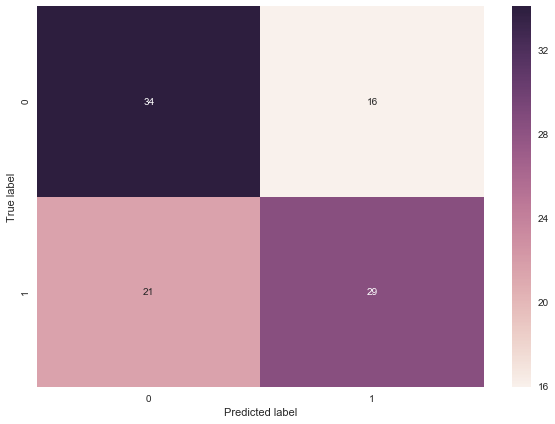

In [12]:
%matplotlib inline
print_mtx(y_test,predicted)

In [17]:
from sklearn.metrics import auc

def plot_roc(roc_auc):
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.4f)' % roc_auc)
    #plt.plot(tpr, fpr, color='darkblue', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Oharacteristic')
    plt.legend(loc="lower right")
    plt.show()

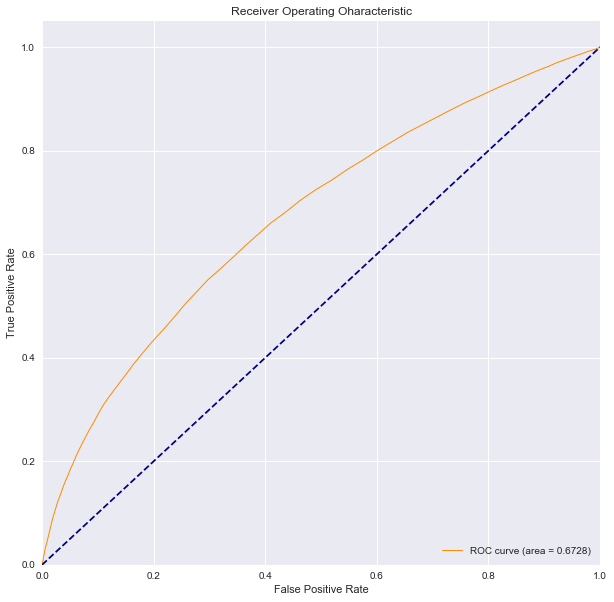

In [18]:
%matplotlib inline
plot_roc(auc(fpr, tpr))

In [16]:
import math
from scipy import stats

position = 0
class_0 = 0
class_1 = 0
counting_class_0 = [0] * 101
counting_class_1 = [0] * 101
grouped_counting_class_0 = [0] * 101
grouped_counting_class_1 = [0] * 101
percentage_counting_class_0 = [0.0] * 101
percentage_counting_class_1 = [0.0] * 101

for x in y_test['y']:
    score = math.floor(y_pred_rf[position]*100)
    if x == 0:
        class_0 = class_0 + 1
        counting_class_0[score] = counting_class_0[score] + 1
    else:
        class_1 = class_1 + 1
        counting_class_1[score]= counting_class_1[score] + 1
    position = position + 1

print(class_0, class_1)

last_value_class_0 = 0
last_value_class_1 = 0

for x in range(0, 101):
    last_value_class_0 += counting_class_0[x]
    grouped_counting_class_0[x] = last_value_class_0
    percentage_counting_class_0[x] = last_value_class_0/class_0
    
    last_value_class_1 += counting_class_1[x]
    grouped_counting_class_1[x] = last_value_class_1
    percentage_counting_class_1[x] = last_value_class_1/class_1

stats.ks_2samp(percentage_counting_class_0, percentage_counting_class_1)
#stats.ks_2samp(grouped_counting_class_0, grouped_counting_class_1)

33525 33524


Ks_2sampResult(statistic=0.16831683168316836, pvalue=0.1024361601437302)

In [14]:
rf2 = RandomForestClassifier(n_estimators=500, oob_score=True, random_state=401, n_jobs=-1, verbose=2)
rf2.fit(X_train.values, y_train.values.ravel())

building tree 1 of 500building tree 2 of 500building tree 3 of 500
building tree 4 of 500
building tree 5 of 500
building tree 6 of 500
building tree 7 of 500


building tree 8 of 500
building tree 9 of 500
building tree 10 of 500
building tree 11 of 500
building tree 12 of 500
building tree 13 of 500
building tree 14 of 500
building tree 15 of 500
building tree 16 of 500
building tree 17 of 500
building tree 18 of 500
building tree 19 of 500
building tree 20 of 500
building tree 21 of 500
building tree 22 of 500
building tree 23 of 500
building tree 24 of 500
building tree 25 of 500
building tree 26 of 500
building tree 27 of 500
building tree 28 of 500
building tree 29 of 500
building tree 30 of 500
building tree 31 of 500
building tree 32 of 500


[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   14.6s


building tree 33 of 500
building tree 34 of 500
building tree 35 of 500
building tree 36 of 500
building tree 37 of 500
building tree 38 of 500
building tree 39 of 500
building tree 40 of 500
building tree 41 of 500
building tree 42 of 500
building tree 43 of 500
building tree 44 of 500
building tree 45 of 500
building tree 46 of 500
building tree 47 of 500
building tree 48 of 500
building tree 49 of 500
building tree 50 of 500
building tree 51 of 500
building tree 52 of 500
building tree 53 of 500
building tree 54 of 500
building tree 55 of 500
building tree 56 of 500
building tree 57 of 500
building tree 58 of 500
building tree 59 of 500
building tree 60 of 500
building tree 61 of 500
building tree 62 of 500
building tree 63 of 500
building tree 64 of 500
building tree 65 of 500
building tree 66 of 500
building tree 67 of 500
building tree 68 of 500
building tree 69 of 500
building tree 70 of 500
building tree 71 of 500
building tree 72 of 500
building tree 73 of 500
building tree 74

[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.2min


building tree 155 of 500
building tree 156 of 500
building tree 157 of 500
building tree 158 of 500
building tree 159 of 500
building tree 160 of 500
building tree 161 of 500
building tree 162 of 500
building tree 163 of 500
building tree 164 of 500
building tree 165 of 500
building tree 166 of 500
building tree 167 of 500
building tree 168 of 500
building tree 169 of 500
building tree 170 of 500
building tree 171 of 500
building tree 172 of 500
building tree 173 of 500
building tree 174 of 500
building tree 175 of 500
building tree 176 of 500
building tree 177 of 500
building tree 178 of 500
building tree 179 of 500
building tree 180 of 500
building tree 181 of 500
building tree 182 of 500
building tree 183 of 500
building tree 184 of 500
building tree 185 of 500
building tree 186 of 500
building tree 187 of 500
building tree 188 of 500
building tree 189 of 500
building tree 190 of 500
building tree 191 of 500
building tree 192 of 500
building tree 193 of 500
building tree 194 of 500


[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  2.9min


building tree 357 of 500
building tree 358 of 500
building tree 359 of 500
building tree 360 of 500
building tree 361 of 500
building tree 362 of 500
building tree 363 of 500
building tree 364 of 500
building tree 365 of 500
building tree 366 of 500
building tree 367 of 500
building tree 368 of 500
building tree 369 of 500
building tree 370 of 500
building tree 371 of 500
building tree 372 of 500
building tree 373 of 500
building tree 374 of 500
building tree 375 of 500
building tree 376 of 500
building tree 377 of 500
building tree 378 of 500
building tree 379 of 500
building tree 380 of 500
building tree 381 of 500
building tree 382 of 500
building tree 383 of 500
building tree 384 of 500
building tree 385 of 500
building tree 386 of 500
building tree 387 of 500
building tree 388 of 500
building tree 389 of 500
building tree 390 of 500
building tree 391 of 500
building tree 392 of 500
building tree 393 of 500
building tree 394 of 500
building tree 395 of 500
building tree 396 of 500


[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:  4.2min finished


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=True, random_state=401, verbose=2, warm_start=False)

In [15]:
predicted = rf2.predict(X_test.values)
y_pred_rf = rf2.predict_proba(X_test)[:, 1]

[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.1s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.4s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    3.5s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    5.0s finished
[Parallel(n_jobs=8)]: Done  25 tasks      | elapsed:    0.2s
[Parallel(n_jobs=8)]: Done 146 tasks      | elapsed:    1.3s
[Parallel(n_jobs=8)]: Done 349 tasks      | elapsed:    3.4s
[Parallel(n_jobs=8)]: Done 500 out of 500 | elapsed:    5.0s finished


In [16]:
accuracy, recall, precision, f1, aupr, fpr, tpr, thresholds, ks = get_metrics(y_test, predicted, y_pred_rf)
print("Accuracy score: {:.3}".format(accuracy))
print("Recall score: {:.3}".format(recall))
print("Precision score: {:.3}".format(precision))
print("f1 score: {:.3}".format(f1))
print("Mean precison score: {:.3}".format(aupr))
print("KS: {:.3}".format(ks[0]))
print("Out-of-bag score estimate: {:.3}".format(rf.oob_score_))

Accuracy score: 0.632
Recall score: 0.58
Precision score: 0.647
f1 score: 0.612
Mean precison score: 0.585
KS: 0.5
Out-of-bag score estimate: 0.619


,0,1
0,22902,10623
1,14075,19449


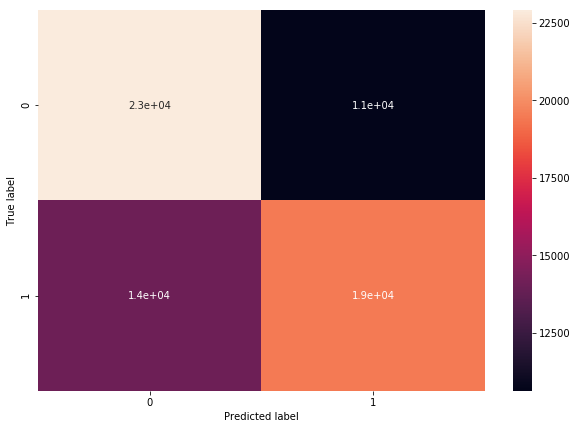

In [17]:
%matplotlib inline
print_mtx(y_test,predicted)

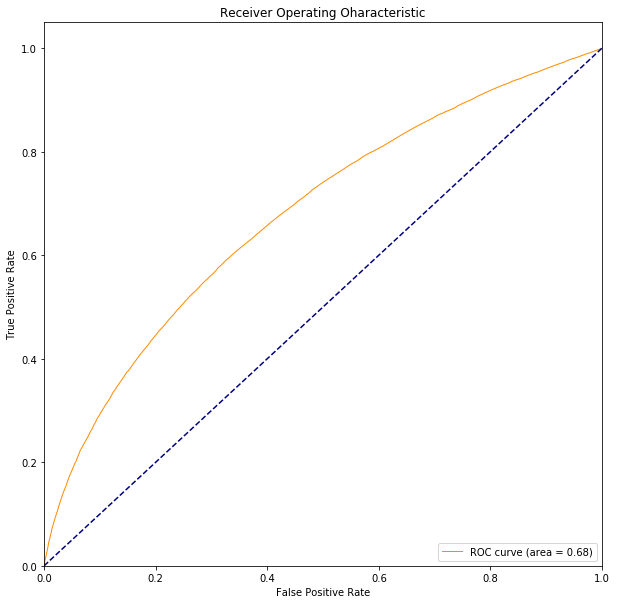

In [18]:
%matplotlib inline
plot_roc(auc(fpr, tpr))

In [28]:
the_test = pd.read_csv("data/real_test_set.csv", sep=',', header=0, low_memory=False)

In [29]:
ft_the_test = the_test.drop('id', 1)

In [32]:
rf_pred_test_class = rf.predict(ft_the_test.values)
rf_pred_test_scores = rf.predict_proba(ft_the_test)[:, 1]

In [33]:
df = pd.DataFrame(data=rf_pred_test_class)
df.to_csv('test.csv', mode='a', index=True)